# Tworzenie Perceptronu - Lista 2

wykorzystamy już przygotowany dataset z listy 1, dane treningowe testowe i walidacyjne z podziałem na cechy i etykiety znajduje się w folderze dataset, będziemy z niego pobierać nasz zbiór.

In [27]:
# Pobieranie danych
import pandas as pd


X_train = pd.read_csv('dataset/X_train.csv')
X_val = pd.read_csv('dataset/X_val.csv')
X_test = pd.read_csv('dataset/X_test.csv')

y_train = pd.read_csv('dataset/y_train.csv')
y_val = pd.read_csv('dataset/y_val.csv')
y_test = pd.read_csv('dataset/y_test.csv')

print(y_train.values.ravel())

[0 0 0 ... 0 0 0]


### Implementacja perceptronu
Zaczinijmy od zrobienia jakiegoś podstawowego perceptronu. W przyszłości potencjalnie go rozszerzymy

In [28]:
# funkcja aktywacji, w naszym przypadku będzie to sigmoid
import numpy as np  # Upewniamy się, że numpy jest dostępne
def sigmoid(z):
        return 1 / (1 + np.exp(-z) + 1e-15)  # dodajemy ekstremalnie małą liczbę aby nigdy nie osiągnąć zera

In [29]:
class perceptron:
    def __init__(self, lr, feats):
        self.weights = np.random.uniform(-0.1, 0.1, size=feats) # ustawiamiy losowe wartości z przedziału -0.1 do 0.1
        self.bias = np.random.uniform(-0.1, 0.1)
        self.lr = lr

    def forward(self, x):
        Z = np.dot(x, self.weights) + self.bias # Obliczamy sumę ważoną: z = w^T * x + b
        A = sigmoid(Z) # Funkcja aktywacji sigmoid
        return A
    


Użyjemy tutaj funkcji straty MSE (mean squared error). W propagacji wstecznej wyliczamy gradienty po losie i po A i przemnażamy je przez siebie. Dodatkowo chcemy uczyć nasz perceptron w mini-batchach, zaimplementujemy więc też  opcję aby trenować go na 3 różne sposoby, po czym przetestujemy jakość wszystkich trzech. Co do wyświetlania wyników to w 1 liście pamiętam, że
accuracy/precision dobrze pokazywało jakość modeli więc tutaj również tę metrykę sprawdzimy.

In [30]:
class Trainer:
    def __init__(self, perceptron, n_epochs, mode = 'batch', batch_size = 32):
        """
        parametry:
            perceptron: model perceptronu
            n_epochs: liczba epok treningowych
            mode: tryb treningu - 'batch', 'sgd', 'mini-batch'
            batch_size: rozmiar paczki (używany tylko gdy mode='mini-batch')
        """
        self.perceptron = perceptron
        self.n_epochs = n_epochs
        self.mode = mode.lower()
        self.batch_size = batch_size
        self.dW = None  # gradient dla wag
        self.dB = None  # gradient dla biasu
        
        self.history_loss = []
        self.history_accuracy = []
        self.history_precision = []
        self.history_f1 = []
        
        if self.mode not in ['batch', 'sgd', 'mini-batch']:
            raise ValueError("mode musi być 'batch', 'sgd' lub 'mini-batch'")

    def loss(self, A, y):
        return np.mean((A - y) ** 2)    
    
    def calculate_metrics(self, X, y): # Oblicza accuracy, precision i f1 score
        predictions = self.predict(X)
        
        # True Positives, False Positives, False Negatives, True Negatives
        TP = np.sum((predictions == 1) & (y == 1))
        FP = np.sum((predictions == 1) & (y == 0))
        FN = np.sum((predictions == 0) & (y == 1))
        TN = np.sum((predictions == 0) & (y == 0))
        
        # Accuracy
        accuracy = (TP + TN) / len(y) if len(y) > 0 else 0
        
        # Precision
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        
        # Recall
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        
        # F1 Score
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        return accuracy, precision, f1

    def backward(self, X, A, y):
        m = X.shape[0]  # liczba próbek
        
        # Gradient straty MSE: dL/dA = 2 * (A - y)
        # Gradient sigmoid: dA/dZ = A * (1 - A)
        dZ = 2 * (A - y) * A * (1 - A)  # mnożymy dL/dA z dA/dZ
        
        # Gradienty dla wag i biasu
        self.dW = np.dot(X.T, dZ) / m
        self.dB = np.sum(dZ) / m

    def update_weights(self):
        self.perceptron.weights -= self.perceptron.lr * self.dW
        self.perceptron.bias -= self.perceptron.lr * self.dB

    def train(self, X, y):
        n_samples = X.shape[0]
        
        # Ustal rozmiar paczki na podstawie trybu
        if self.mode == 'batch':
            effective_batch_size = n_samples  # cały zbiór
        elif self.mode == 'sgd':
            effective_batch_size = 1  # pojedyncze próbki
        elif self.mode == 'mini-batch':
            effective_batch_size = self.batch_size
        else:
            raise ValueError("Nieznany tryb treningu.")
        
        for epoch in range(self.n_epochs):
            # Shuffle danych na początku każdej epoki
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            
            epoch_loss = 0
            n_batches = 0
            
            for i in range(0, n_samples, effective_batch_size):
                # Pobranie paczki
                X_batch = X_shuffled[i:i + effective_batch_size]
                y_batch = y_shuffled[i:i + effective_batch_size]
                
                # Forward pass
                A = self.perceptron.forward(X_batch)
                
                # Obliczanie straty dla paczki
                batch_loss = self.loss(A, y_batch)
                epoch_loss += batch_loss
                n_batches += 1
                
                # Backward pass
                self.backward(X_batch, A, y_batch)
                
                # Aktualizacja wag
                self.update_weights()
            
            # Średnia strata w epoce
            avg_epoch_loss = epoch_loss / n_batches
            
            # Zapisywanie metryk co epokę
            accuracy, precision, f1 = self.calculate_metrics(X, y)
            
            self.history_loss.append(avg_epoch_loss)
            self.history_accuracy.append(accuracy)
            self.history_precision.append(precision)
            self.history_f1.append(f1)
            
            # Wyświetlanie co 100 epok
            if (epoch + 1) % 100 == 0:
                mode_info = f"{self.mode.upper()}"
                if self.mode == 'mini-batch':
                    mode_info += f" (batch_size={effective_batch_size})"
                print(f"Epoch {epoch + 1}/{self.n_epochs} [{mode_info}] - Loss: {avg_epoch_loss:.6f}, Acc: {accuracy:.4f}, Prec: {precision:.4f}, F1: {f1:.4f}")

    def predict(self, X):
        A = self.perceptron.forward(X)
        # Konwersja prawdopodobieństw na klasy (0 lub 1)
        return (A >= 0.5).astype(int)

### Trening modelu
Wytrenujemy perceptron na trzech różnych trybach i porównamy wyniki

In [31]:
# Przygotowanie danych
# Konwersja bool na int przed utworzeniem array
seed = 42
np.random.seed(seed)

X_train_array = X_train.astype(float).values
y_train_array = y_train.values.ravel()

X_val_array = X_val.astype(float).values
y_val_array = y_val.values.ravel()

X_test_array = X_test.astype(float).values
y_test_array = y_test.values.ravel()

print(f"Kształt danych treningowych: X={X_train_array.shape}, y={y_train_array.shape}")
print(f"Liczba cech: {X_train_array.shape[1]}")

Kształt danych treningowych: X=(36168, 29), y=(36168,)
Liczba cech: 29


In [32]:
# Trening 1: Batch Gradient Descent
model_batch = perceptron(lr=0.01, feats=X_train_array.shape[1])
trainer_batch = Trainer(model_batch, n_epochs=1000, mode='batch')
trainer_batch.train(X_train_array, y_train_array)

# Ewaluacja na zbiorze testowym
test_predictions_batch = trainer_batch.predict(X_test_array)
test_acc_batch, test_prec_batch, test_f1_batch = trainer_batch.calculate_metrics(X_test_array, y_test_array)

print(f"\nWyniki na zbiorze testowym:")
print(f"Accuracy: {test_acc_batch:.4f}")
print(f"Precision: {test_prec_batch:.4f}")
print(f"F1 Score: {test_f1_batch:.4f}")

Epoch 100/1000 [BATCH] - Loss: 0.167140, Acc: 0.8829, Prec: 0.2105, F1: 0.0019
Epoch 200/1000 [BATCH] - Loss: 0.138070, Acc: 0.8832, Prec: 0.5000, F1: 0.0014
Epoch 300/1000 [BATCH] - Loss: 0.124622, Acc: 0.8831, Prec: 0.4286, F1: 0.0014
Epoch 400/1000 [BATCH] - Loss: 0.117397, Acc: 0.8831, Prec: 0.3750, F1: 0.0014
Epoch 500/1000 [BATCH] - Loss: 0.113055, Acc: 0.8830, Prec: 0.2727, F1: 0.0014
Epoch 600/1000 [BATCH] - Loss: 0.110223, Acc: 0.8830, Prec: 0.2727, F1: 0.0014
Epoch 700/1000 [BATCH] - Loss: 0.108260, Acc: 0.8830, Prec: 0.2308, F1: 0.0014
Epoch 800/1000 [BATCH] - Loss: 0.106832, Acc: 0.8829, Prec: 0.2000, F1: 0.0014
Epoch 900/1000 [BATCH] - Loss: 0.105752, Acc: 0.8829, Prec: 0.2353, F1: 0.0019
Epoch 1000/1000 [BATCH] - Loss: 0.104910, Acc: 0.8829, Prec: 0.2778, F1: 0.0024

Wyniki na zbiorze testowym:
Accuracy: 0.8834
Precision: 0.0000
F1 Score: 0.0000


In [33]:
# Trening 2: Stochastic Gradient Descent

model_sgd = perceptron(lr=0.01, feats=X_train_array.shape[1])
trainer_sgd = Trainer(model_sgd, n_epochs=1000, mode='sgd')
trainer_sgd.train(X_train_array, y_train_array)

# Ewaluacja na zbiorze testowym
test_predictions_sgd = trainer_sgd.predict(X_test_array)
test_acc_sgd, test_prec_sgd, test_f1_sgd = trainer_sgd.calculate_metrics(X_test_array, y_test_array)

print(f"\nWyniki na zbiorze testowym:")
print(f"Accuracy: {test_acc_sgd:.4f}")
print(f"Precision: {test_prec_sgd:.4f}")
print(f"F1 Score: {test_f1_sgd:.4f}")

Epoch 100/1000 [SGD] - Loss: 0.088983, Acc: 0.8940, Prec: 0.6874, F1: 0.2722
Epoch 200/1000 [SGD] - Loss: 0.088995, Acc: 0.8940, Prec: 0.6937, F1: 0.2680
Epoch 300/1000 [SGD] - Loss: 0.088984, Acc: 0.8937, Prec: 0.6715, F1: 0.2796
Epoch 400/1000 [SGD] - Loss: 0.088951, Acc: 0.8939, Prec: 0.6921, F1: 0.2670
Epoch 500/1000 [SGD] - Loss: 0.088974, Acc: 0.8939, Prec: 0.6887, F1: 0.2701
Epoch 600/1000 [SGD] - Loss: 0.088994, Acc: 0.8940, Prec: 0.6841, F1: 0.2764
Epoch 700/1000 [SGD] - Loss: 0.088990, Acc: 0.8941, Prec: 0.6861, F1: 0.2760
Epoch 800/1000 [SGD] - Loss: 0.088959, Acc: 0.8940, Prec: 0.6842, F1: 0.2758
Epoch 900/1000 [SGD] - Loss: 0.088988, Acc: 0.8938, Prec: 0.6919, F1: 0.2654
Epoch 1000/1000 [SGD] - Loss: 0.088987, Acc: 0.8941, Prec: 0.6871, F1: 0.2752

Wyniki na zbiorze testowym:
Accuracy: 0.8885
Precision: 0.5873
F1 Score: 0.2270


In [34]:
# Trening 3: Mini-Batch Stochastic Gradient Descent

model_minibatch = perceptron(lr=0.01, feats=X_train_array.shape[1])
trainer_minibatch = Trainer(model_minibatch, n_epochs=1000, mode='mini-batch', batch_size=32)
trainer_minibatch.train(X_train_array, y_train_array)

# Ewaluacja na zbiorze testowym
test_predictions_minibatch = trainer_minibatch.predict(X_test_array)
test_acc_minibatch, test_prec_minibatch, test_f1_minibatch = trainer_minibatch.calculate_metrics(X_test_array, y_test_array)

print(f"\nWyniki na zbiorze testowym:")
print(f"Accuracy: {test_acc_minibatch:.4f}")
print(f"Precision: {test_prec_minibatch:.4f}")
print(f"F1 Score: {test_f1_minibatch:.4f}")

Epoch 100/1000 [MINI-BATCH (batch_size=32)] - Loss: 0.088975, Acc: 0.8939, Prec: 0.6937, F1: 0.2653
Epoch 200/1000 [MINI-BATCH (batch_size=32)] - Loss: 0.088794, Acc: 0.8942, Prec: 0.6928, F1: 0.2726
Epoch 300/1000 [MINI-BATCH (batch_size=32)] - Loss: 0.088769, Acc: 0.8941, Prec: 0.6910, F1: 0.2727
Epoch 400/1000 [MINI-BATCH (batch_size=32)] - Loss: 0.088947, Acc: 0.8940, Prec: 0.6888, F1: 0.2723
Epoch 500/1000 [MINI-BATCH (batch_size=32)] - Loss: 0.088678, Acc: 0.8941, Prec: 0.6901, F1: 0.2724
Epoch 600/1000 [MINI-BATCH (batch_size=32)] - Loss: 0.088743, Acc: 0.8940, Prec: 0.6888, F1: 0.2723
Epoch 700/1000 [MINI-BATCH (batch_size=32)] - Loss: 0.088688, Acc: 0.8941, Prec: 0.6914, F1: 0.2725
Epoch 800/1000 [MINI-BATCH (batch_size=32)] - Loss: 0.088683, Acc: 0.8941, Prec: 0.6901, F1: 0.2724
Epoch 900/1000 [MINI-BATCH (batch_size=32)] - Loss: 0.088683, Acc: 0.8941, Prec: 0.6901, F1: 0.2724
Epoch 1000/1000 [MINI-BATCH (batch_size=32)] - Loss: 0.088737, Acc: 0.8940, Prec: 0.6888, F1: 0.2723

sgd i mini batche osiągają podobny wynik, deklasując batch gradient descent, więc w ramach następnych testów będziemy używać sgd

In [35]:
mode = 'sgd'

### Porównanie różnych learning rate i liczby epok
Przetestujemy model dla 3 różnych wartości learning rate oraz 3 różnych liczb epok, aby zobaczyć jak te hiperparametry wpływają na proces uczenia

In [36]:
import matplotlib.pyplot as plt

# Różne learning rates (przy stałej liczbie epok)
learning_rates = [0.001, 0.01, 0.1]
n_epochs_fixed = 1000

models_lr = []
trainers_lr = []

for lr in learning_rates:
    print(f"\nTrening dla learning rate = {lr}")
    model = perceptron(lr=lr, feats=X_train_array.shape[1])
    trainer = Trainer(model, n_epochs=n_epochs_fixed, mode=mode)
    trainer.train(X_train_array, y_train_array)
    
    models_lr.append(model)
    trainers_lr.append(trainer)
    
    test_acc, test_prec, test_f1 = trainer.calculate_metrics(X_test_array, y_test_array)
    print(f"Test - Acc: {test_acc:.4f}, Prec: {test_prec:.4f}, F1: {test_f1:.4f}")

# Różne liczby epok (przy stałym learning rate)
epochs_list = [500, 1000, 2000]
lr_fixed = 0.01

models_epochs = []
trainers_epochs = []

for n_epochs in epochs_list:
    print(f"\nTrening dla {n_epochs} epok")
    model = perceptron(lr=lr_fixed, feats=X_train_array.shape[1])
    trainer = Trainer(model, n_epochs=n_epochs, mode=mode)
    trainer.train(X_train_array, y_train_array)
    
    models_epochs.append(model)
    trainers_epochs.append(trainer)
    
    test_acc, test_prec, test_f1 = trainer.calculate_metrics(X_test_array, y_test_array)
    print(f"Test - Acc: {test_acc:.4f}, Prec: {test_prec:.4f}, F1: {test_f1:.4f}")




Trening dla learning rate = 0.001
Epoch 100/1000 [SGD] - Loss: 0.088765, Acc: 0.8942, Prec: 0.6931, F1: 0.2723
Epoch 200/1000 [SGD] - Loss: 0.088760, Acc: 0.8940, Prec: 0.6874, F1: 0.2722
Epoch 300/1000 [SGD] - Loss: 0.088758, Acc: 0.8941, Prec: 0.6915, F1: 0.2719
Epoch 400/1000 [SGD] - Loss: 0.088759, Acc: 0.8941, Prec: 0.6912, F1: 0.2715
Epoch 500/1000 [SGD] - Loss: 0.088758, Acc: 0.8940, Prec: 0.6888, F1: 0.2723
Epoch 600/1000 [SGD] - Loss: 0.088755, Acc: 0.8941, Prec: 0.6940, F1: 0.2705
Epoch 700/1000 [SGD] - Loss: 0.088759, Acc: 0.8939, Prec: 0.6868, F1: 0.2721
Epoch 800/1000 [SGD] - Loss: 0.088759, Acc: 0.8941, Prec: 0.6901, F1: 0.2724
Epoch 900/1000 [SGD] - Loss: 0.088757, Acc: 0.8941, Prec: 0.6901, F1: 0.2724
Epoch 1000/1000 [SGD] - Loss: 0.088755, Acc: 0.8940, Prec: 0.6871, F1: 0.2724
Test - Acc: 0.8881, Prec: 0.5794, F1: 0.2239

Trening dla learning rate = 0.01
Epoch 100/1000 [SGD] - Loss: 0.088989, Acc: 0.8941, Prec: 0.6919, F1: 0.2710
Epoch 200/1000 [SGD] - Loss: 0.089014,

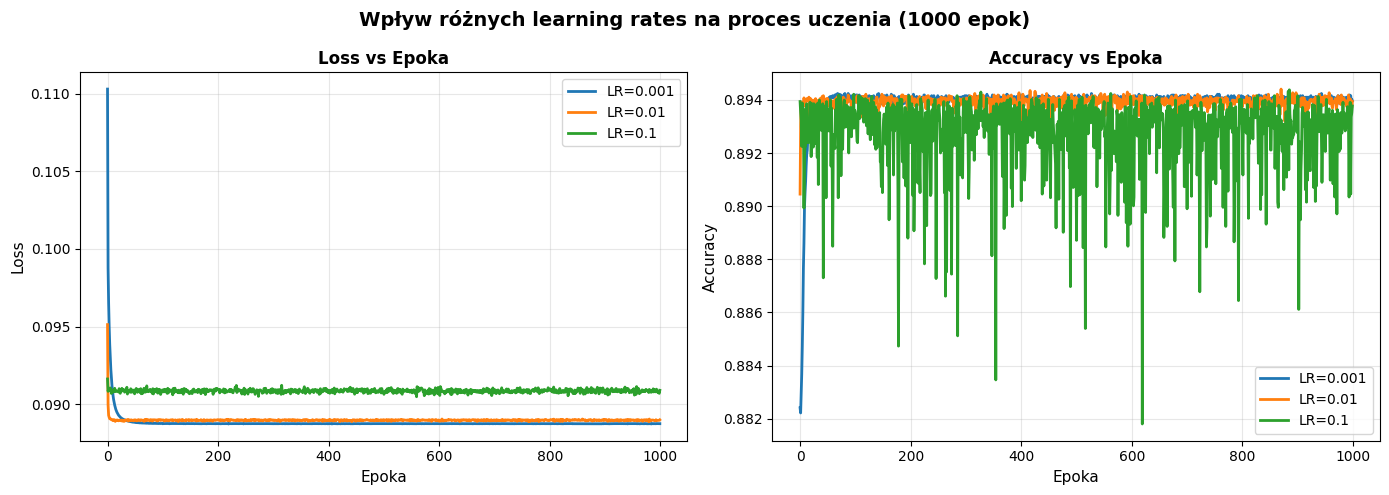

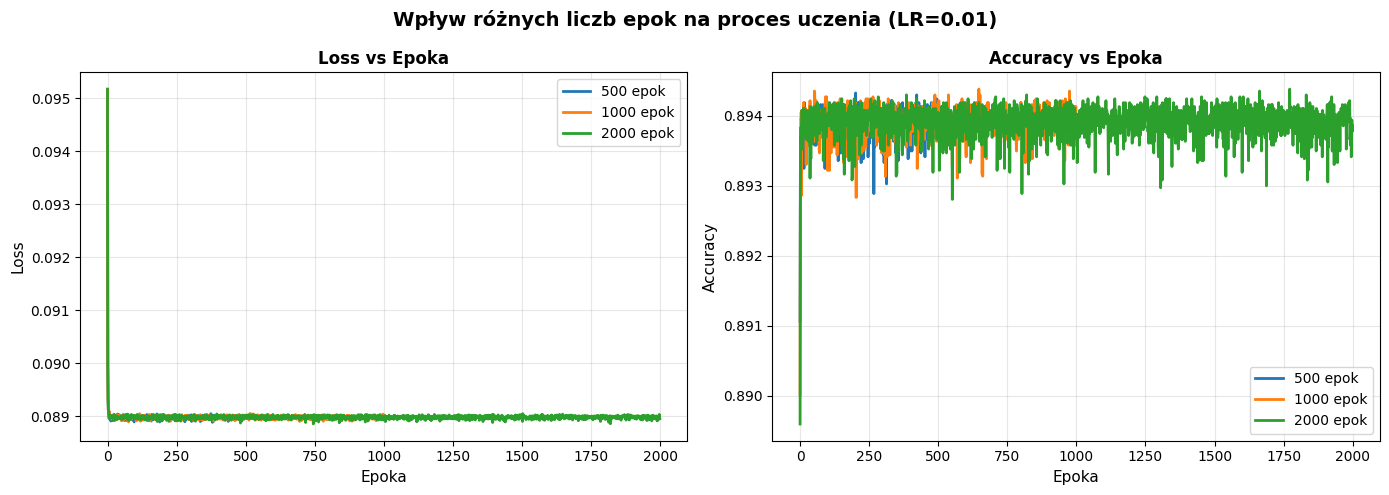


Wpływ Learning Rate :
LR=0.001 -> Acc: 0.8881, Prec: 0.5794, F1: 0.2239
LR=0.010 -> Acc: 0.8881, Prec: 0.5806, F1: 0.2215
LR=0.100 -> Acc: 0.8885, Prec: 0.5917, F1: 0.2198

Wpływ liczby epok :
500 epok -> Acc: 0.8885, Prec: 0.5948, F1: 0.2150
1000 epok -> Acc: 0.8894, Prec: 0.5929, F1: 0.2492
2000 epok -> Acc: 0.8883, Prec: 0.5868, F1: 0.2195


In [37]:
# Wykres dla różnych learning rates
fig1, axes1 = plt.subplots(1, 2, figsize=(14, 5))
fig1.suptitle('Wpływ różnych learning rates na proces uczenia (1000 epok)', fontsize=14, fontweight='bold')

metrics = ['Loss', 'Accuracy']
histories = ['history_loss', 'history_accuracy']

for idx, (metric, history) in enumerate(zip(metrics, histories)):
    ax = axes1[idx]
    for i, (trainer, lr) in enumerate(zip(trainers_lr, learning_rates)):
        ax.plot(getattr(trainer, history), label=f'LR={lr}', linewidth=2)
    ax.set_xlabel('Epoka', fontsize=11)
    ax.set_ylabel(metric, fontsize=11)
    ax.set_title(f'{metric} vs Epoka', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Wykres dla różnych liczb epok
fig2, axes2 = plt.subplots(1, 2, figsize=(14, 5))
fig2.suptitle('Wpływ różnych liczb epok na proces uczenia (LR=0.01)', fontsize=14, fontweight='bold')

for idx, (metric, history) in enumerate(zip(metrics, histories)):
    ax = axes2[idx]
    for i, (trainer, n_epochs) in enumerate(zip(trainers_epochs, epochs_list)):
        ax.plot(getattr(trainer, history), label=f'{n_epochs} epok', linewidth=2)
    ax.set_xlabel('Epoka', fontsize=11)
    ax.set_ylabel(metric, fontsize=11)
    ax.set_title(f'{metric} vs Epoka', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


print("\nWpływ Learning Rate :")
for i, lr in enumerate(learning_rates):
    test_acc, test_prec, test_f1 = trainers_lr[i].calculate_metrics(X_test_array, y_test_array)
    print(f"LR={lr:5.3f} -> Acc: {test_acc:.4f}, Prec: {test_prec:.4f}, F1: {test_f1:.4f}")

print("\nWpływ liczby epok :")
for i, n_epochs in enumerate(epochs_list):
    test_acc, test_prec, test_f1 = trainers_epochs[i].calculate_metrics(X_test_array, y_test_array)
    print(f"{n_epochs} epok -> Acc: {test_acc:.4f}, Prec: {test_prec:.4f}, F1: {test_f1:.4f}")

No ewidentnie poleciałem z tą liczbą epok, model zaczyna oscylować w okolicach wartości optymalnej dosyć szybko i nie trzeba było robić tak dużej ich ilości. Z dodatkowych wniosków widzimy, że lr na poziomie 0.1 jest za duży i mocno "skacze" zamiast natrafić na najlepszy wynik, w tej kwesti najlepszy wydaje się lr wynoszący 0.001, ale różnice między tymi wartościami nie są znaczące. Warto też wspomnieć o tym, że są to wyniki dla zarówno y = 0 jak i y = 1, gdzie w zad1 pokazaliśmy że model nie radzi sobie tak dobrze z wykrywaniem 1 jak z 0 więc acc na poziomie 0.89 może być mylące, warto o tym wspomnieć, nie mniej wartości te są podobne co te w liście 1 więc już nie wykonując testów myślę że mogę założyć iż wyniki jest podobny.

### Jednowarstwowa sieć MLP z PyTorch
Teraz zaimplementujemy jednowarstwowy perceptron przy użyciu PyTorch i porównamy wyniki z naszą własną implementacją
Użyjemy takich samych hiperparametrów co przy ręcznej implementacji. zrobimy to na 100 epokach i lr = 0.01 a jako optymalizator wybierzemy Adama (kto by sie spodziewał)

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class SingleLayerMLP(nn.Module):
    def __init__(self, input_size):
        super(SingleLayerMLP, self).__init__()
        self.linear = nn.Linear(input_size, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        z = self.linear(x)
        output = self.sigmoid(z)
        return output

# Konwersja danych do tensorów PyTorch
X_train_tensor = torch.FloatTensor(X_train_array).to(device)
y_train_tensor = torch.FloatTensor(y_train_array.reshape(-1, 1)).to(device)

X_test_tensor = torch.FloatTensor(X_test_array).to(device)
y_test_tensor = torch.FloatTensor(y_test_array.reshape(-1, 1)).to(device)

input_size = X_train_array.shape[1]
model_pytorch = SingleLayerMLP(input_size).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model_pytorch.parameters(), lr=0.01)  

# Historia treningu
history_loss_pytorch = []
history_accuracy_pytorch = []


In [39]:
# robie jeszcze raz tę funkcję, bo tamta była wewnątrz klasy
def calculate_metrics_pytorch(model, X, y):
    model.eval()
    with torch.no_grad():
        predictions = model(X)
        predictions = (predictions >= 0.5).float()
        
        # True Positives, False Positives, False Negatives, True Negatives
        TP = ((predictions == 1) & (y == 1)).sum().item()
        FP = ((predictions == 1) & (y == 0)).sum().item()
        FN = ((predictions == 0) & (y == 1)).sum().item()
        TN = ((predictions == 0) & (y == 0)).sum().item()
        
        # Accuracy
        accuracy = (TP + TN) / len(y) if len(y) > 0 else 0
        
        # Precision
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        
        # Recall
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        
        # F1 Score
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
    return accuracy, precision, f1

# Trening modelu
n_epochs = 1000

for epoch in range(n_epochs):
    model_pytorch.train()
    
    # Forward pass
    outputs = model_pytorch(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward pass i optymalizacja
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Obliczanie metryk co epokę
    accuracy, precision, f1 = calculate_metrics_pytorch(model_pytorch, X_train_tensor, y_train_tensor)
    
    history_loss_pytorch.append(loss.item())
    history_accuracy_pytorch.append(accuracy)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{n_epochs} - Loss: {loss.item():.6f}, Acc: {accuracy:.4f}, Prec: {precision:.4f}, F1: {f1:.4f}")

# Ewaluacja na zbiorze testowym
test_acc_pytorch, test_prec_pytorch, test_f1_pytorch = calculate_metrics_pytorch(
    model_pytorch, X_test_tensor, y_test_tensor
)

print(f"\nWyniki na zbiorze testowym (PyTorch):")
print(f"Accuracy: {test_acc_pytorch:.4f}")
print(f"Precision: {test_prec_pytorch:.4f}")
print(f"F1 Score: {test_f1_pytorch:.4f}")

Epoch 10/1000 - Loss: 0.196727, Acc: 0.8600, Prec: 0.2462, F1: 0.1385
Epoch 20/1000 - Loss: 0.139910, Acc: 0.8802, Prec: 0.4022, F1: 0.0929
Epoch 30/1000 - Loss: 0.116241, Acc: 0.8820, Prec: 0.4465, F1: 0.0742
Epoch 40/1000 - Loss: 0.106567, Acc: 0.8830, Prec: 0.4911, F1: 0.0612
Epoch 50/1000 - Loss: 0.102160, Acc: 0.8839, Prec: 0.5512, F1: 0.0625
Epoch 60/1000 - Loss: 0.099771, Acc: 0.8845, Prec: 0.5872, F1: 0.0732
Epoch 70/1000 - Loss: 0.098227, Acc: 0.8853, Prec: 0.6152, F1: 0.0891
Epoch 80/1000 - Loss: 0.097098, Acc: 0.8863, Prec: 0.6390, F1: 0.1130
Epoch 90/1000 - Loss: 0.096210, Acc: 0.8868, Prec: 0.6462, F1: 0.1256
Epoch 100/1000 - Loss: 0.095478, Acc: 0.8877, Prec: 0.6621, F1: 0.1423
Epoch 110/1000 - Loss: 0.094863, Acc: 0.8881, Prec: 0.6573, F1: 0.1560
Epoch 120/1000 - Loss: 0.094337, Acc: 0.8888, Prec: 0.6667, F1: 0.1694
Epoch 130/1000 - Loss: 0.093884, Acc: 0.8891, Prec: 0.6616, F1: 0.1792
Epoch 140/1000 - Loss: 0.093490, Acc: 0.8897, Prec: 0.6667, F1: 0.1906
Epoch 150/1000 

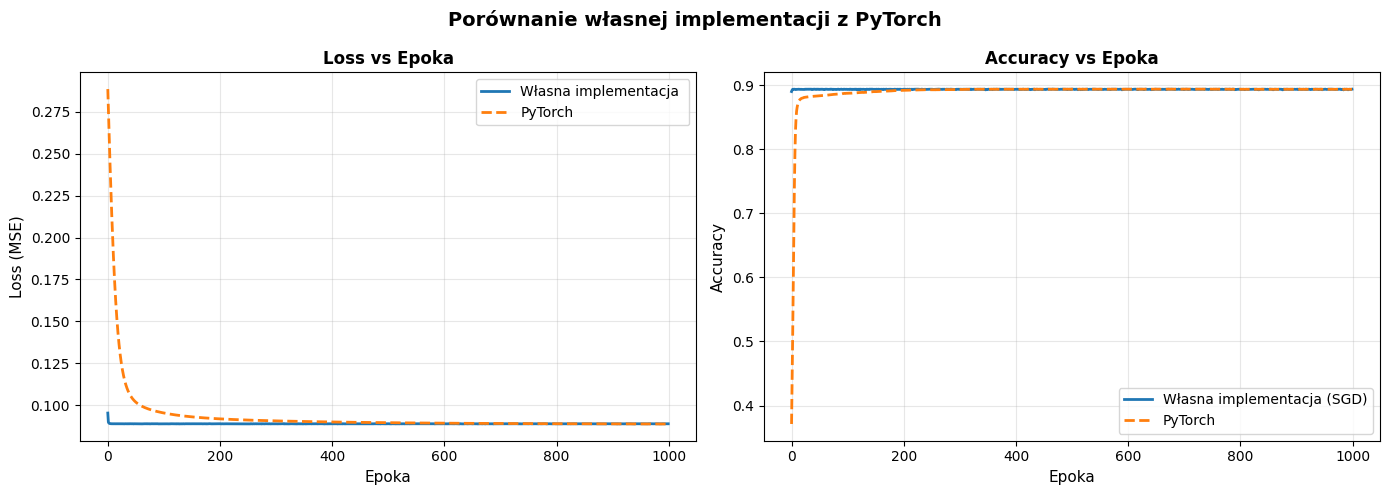


Własna implementacja :
  Accuracy:  0.8885
  Precision: 0.5873
  F1 Score:  0.2270

PyTorch:
  Accuracy:  0.8890
  Precision: 0.5938
  F1 Score:  0.2324


In [40]:
# Porównanie z naszą własną implementacją
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Porównanie własnej implementacji z PyTorch', fontsize=14, fontweight='bold')

# Wykres Loss
axes[0].plot(trainer_sgd.history_loss, label='Własna implementacja ', linewidth=2)
axes[0].plot(history_loss_pytorch, label='PyTorch', linewidth=2, linestyle='--')
axes[0].set_xlabel('Epoka', fontsize=11)
axes[0].set_ylabel('Loss (MSE)', fontsize=11)
axes[0].set_title('Loss vs Epoka', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Wykres Accuracy
axes[1].plot(trainer_sgd.history_accuracy, label='Własna implementacja (SGD)', linewidth=2)
axes[1].plot(history_accuracy_pytorch, label='PyTorch', linewidth=2, linestyle='--')
axes[1].set_xlabel('Epoka', fontsize=11)
axes[1].set_ylabel('Accuracy', fontsize=11)
axes[1].set_title('Accuracy vs Epoka', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Porównanie wyników końcowych
print(f"\nWłasna implementacja :")
print(f"  Accuracy:  {test_acc_sgd:.4f}")
print(f"  Precision: {test_prec_sgd:.4f}")
print(f"  F1 Score:  {test_f1_sgd:.4f}")

print(f"\nPyTorch:")
print(f"  Accuracy:  {test_acc_pytorch:.4f}")
print(f"  Precision: {test_prec_pytorch:.4f}")
print(f"  F1 Score:  {test_f1_pytorch:.4f}")



Oba modele osiągnęły niemalże identyczne wyniki, na wykresie widzimy że przez Adama, model pytorchowy szybciej zbliżył się do optimum ale z czasem oba modele przybierały wartości z bardzo bliskiego zakresu. Nasz nauczony perceptron daje nam wyniki bardzo zbliżone do tych, które osiągnąłem w 1 liście, więc nie będę drugi raz ich omawiać ale myślę że samo działanie perceptronu zostało tu przedstawione a wynik podobny do modeli zrobionych przy użyciu bibliotek to powinien potwierdzać.